In [2]:
import pandas as pd
import numpy as np
from scipy import stats
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split 
import xgboost as xgb
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV

In [3]:
train_data = pd.read_csv("data/train.csv")
test_data = pd.read_csv("data/test.csv")

In [4]:
train_data.head()

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,False
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,True


In [5]:
test_data.head()

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name
0,0013_01,Earth,True,G/3/S,TRAPPIST-1e,27.0,False,0.0,0.0,0.0,0.0,0.0,Nelly Carsoning
1,0018_01,Earth,False,F/4/S,TRAPPIST-1e,19.0,False,0.0,9.0,0.0,2823.0,0.0,Lerome Peckers
2,0019_01,Europa,True,C/0/S,55 Cancri e,31.0,False,0.0,0.0,0.0,0.0,0.0,Sabih Unhearfus
3,0021_01,Europa,False,C/1/S,TRAPPIST-1e,38.0,False,0.0,6652.0,0.0,181.0,585.0,Meratz Caltilter
4,0023_01,Earth,False,F/5/S,TRAPPIST-1e,20.0,False,10.0,0.0,635.0,0.0,0.0,Brence Harperez


In [6]:
train_data.describe()

,Age,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck
count,8514.000000,8512.000000,8510.000000,8485.000000,8510.000000,8505.000000
mean,28.827930,224.687617,458.077203,173.729169,311.138778,304.854791
std,14.489021,666.717663,1611.489240,604.696458,1136.705535,1145.717189
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,19.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,27.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,38.000000,47.000000,76.000000,27.000000,59.000000,46.000000
max,79.000000,14327.000000,29813.000000,23492.000000,22408.000000,24133.000000


## First we visualize the data

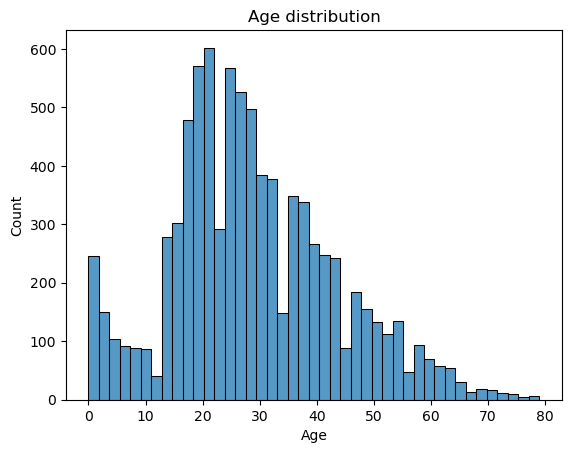

In [7]:
sns.histplot(x=train_data['Age']);
plt.title("Age distribution");
plt.show()

<font size="3">It can be noticed that mostly people aged from 13-38 years are on the spaceship.</font>

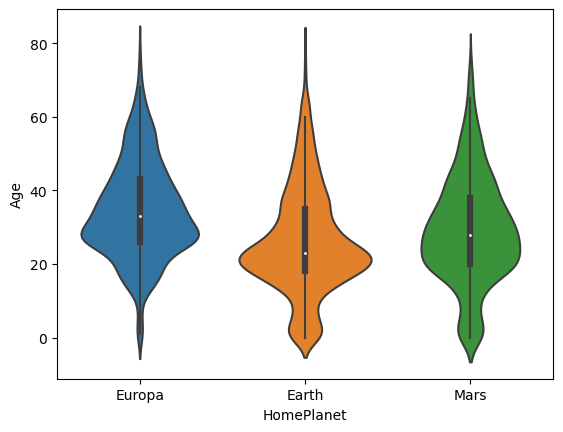

In [8]:
sns.violinplot(x=train_data['HomePlanet'],y=train_data['Age']);

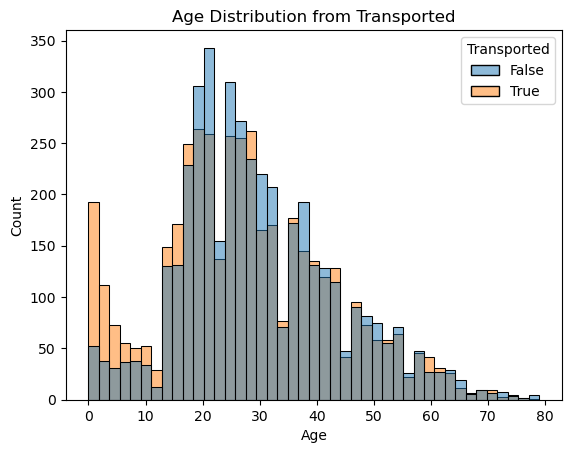

In [9]:
sns.histplot(x=train_data['Age'], hue=train_data['Transported']);
plt.title("Age Distribution from Transported");
plt.show()

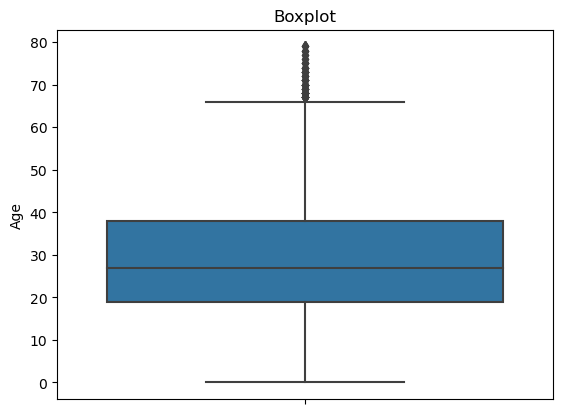

In [10]:
sns.boxplot(y=train_data['Age']);
plt.title("Boxplot");
plt.show();

<font size="3">According to the boxplot graph, you can see that the age column has outliers. We will take this into account in the future.</font>

In [11]:
list_col = ['HomePlanet', 'CryoSleep', 'Destination', 'Age',
       'VIP', 'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck', 'Transported']

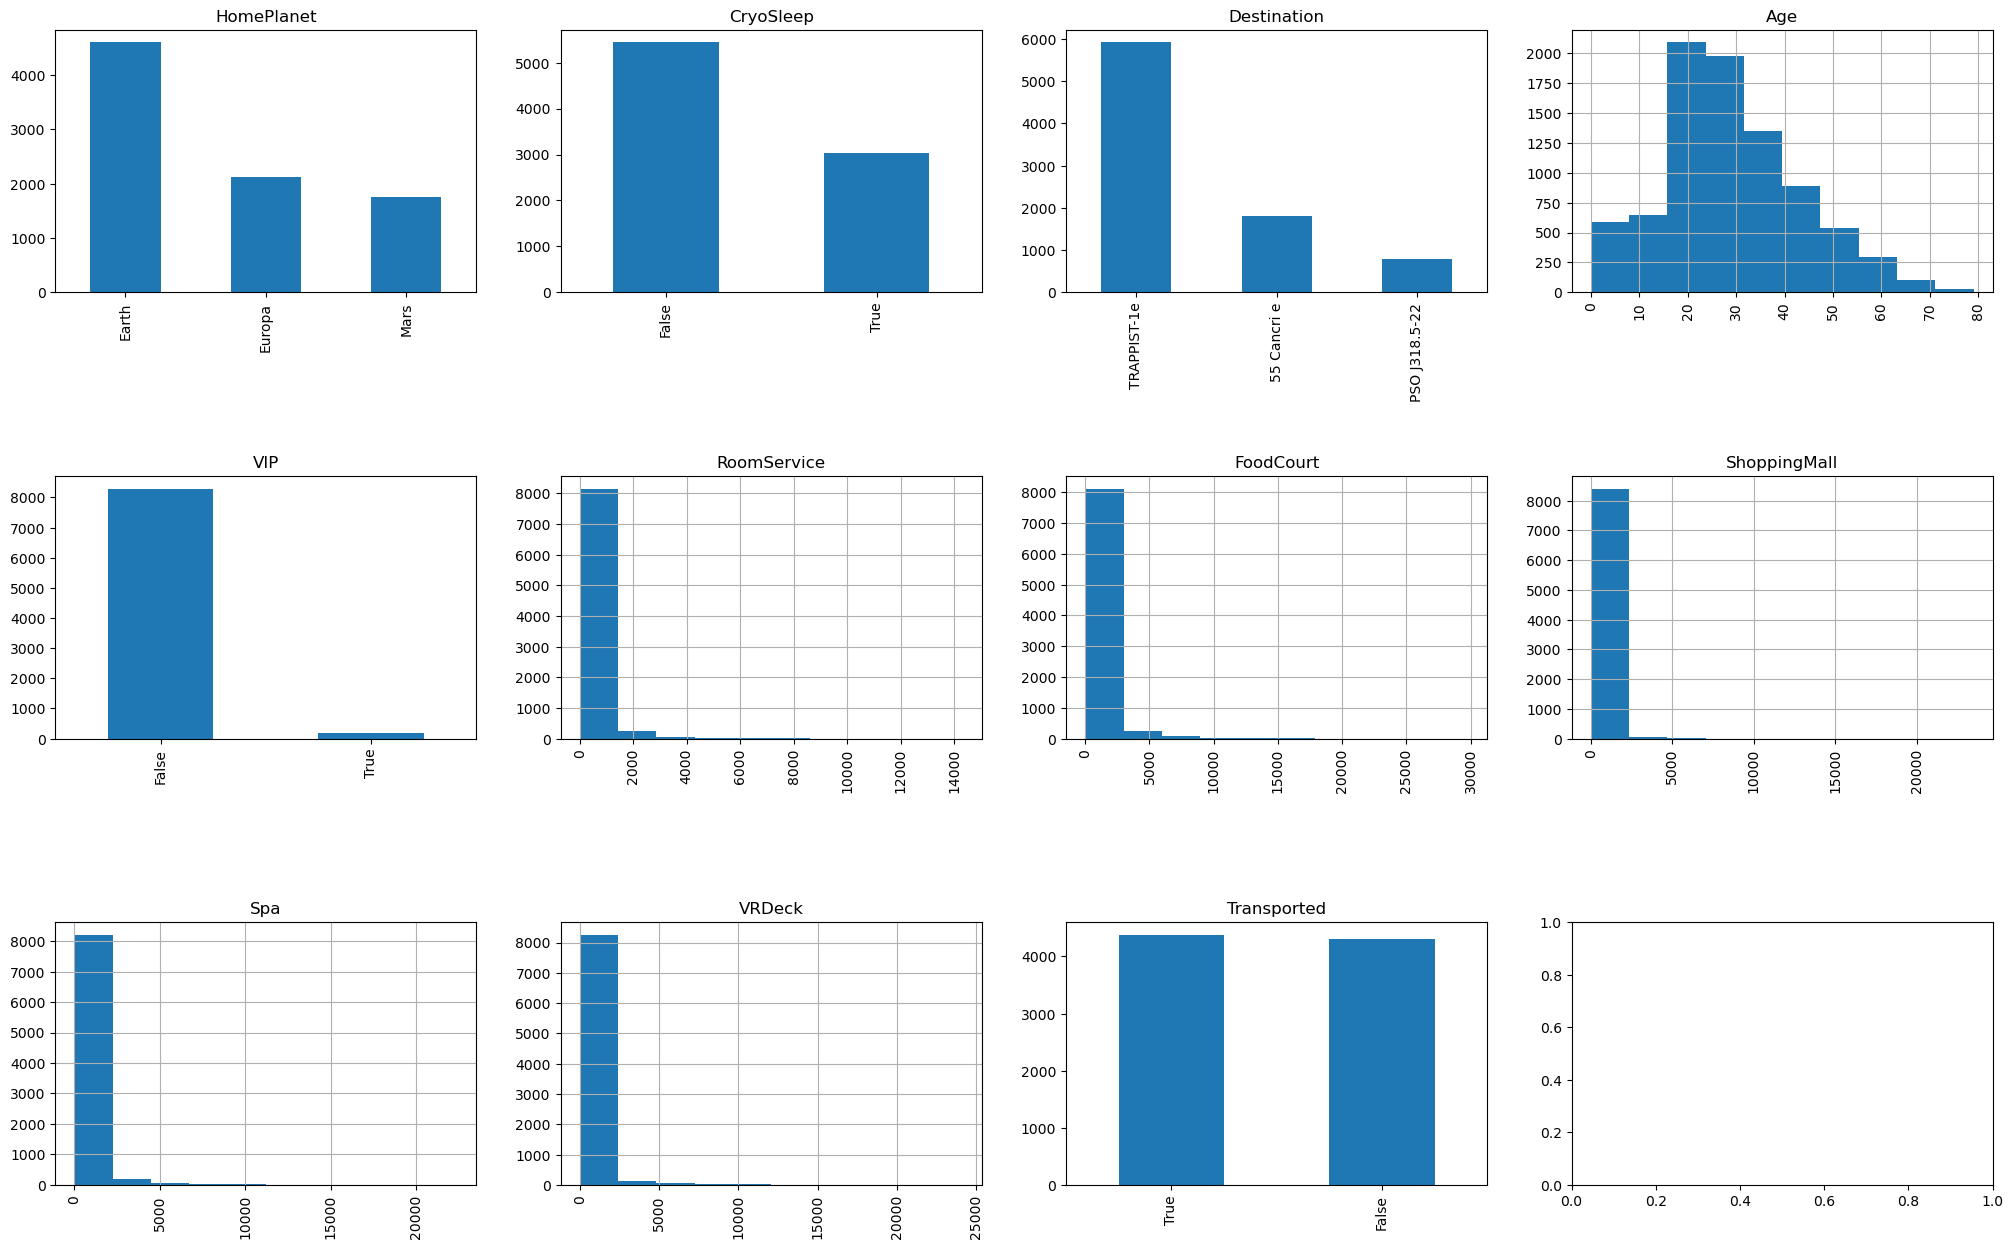

In [12]:
fig = plt.figure(figsize=(25, 15))
cols = 4
rows = (len(list_col) + cols - 1) // cols 

for i, col in enumerate(list_col):
    ax = fig.add_subplot(rows, cols, i+1)
    ax.set_title(col)
    if train_data[col].dtype == object or train_data[col].dtype == bool:
        train_data[col].value_counts().plot(kind="bar", ax=ax)
    else:
        train_data[col].hist(ax=ax)
        plt.xticks(rotation='vertical')

# Adding an "empty" subplot to fill in the "gap"
if len(list_col) % cols != 0:
    for _ in range(cols - (len(list_col) % cols)):
        fig.add_subplot(rows, cols, len(list_col) + 1)

plt.subplots_adjust(hspace=0.7, wspace=0.2)
plt.show()

<font size="3">Correlation between variables.</font>

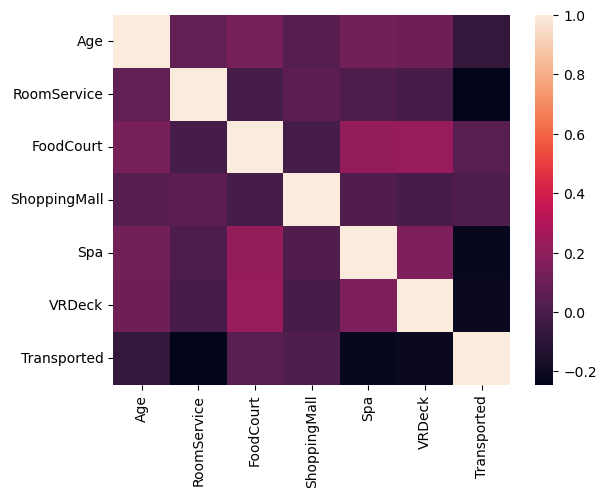

In [14]:
sns.heatmap(train_data.corr());

## Data preparation

In [15]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8693 entries, 0 to 8692
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   PassengerId   8693 non-null   object 
 1   HomePlanet    8492 non-null   object 
 2   CryoSleep     8476 non-null   object 
 3   Cabin         8494 non-null   object 
 4   Destination   8511 non-null   object 
 5   Age           8514 non-null   float64
 6   VIP           8490 non-null   object 
 7   RoomService   8512 non-null   float64
 8   FoodCourt     8510 non-null   float64
 9   ShoppingMall  8485 non-null   float64
 10  Spa           8510 non-null   float64
 11  VRDeck        8505 non-null   float64
 12  Name          8493 non-null   object 
 13  Transported   8693 non-null   bool   
dtypes: bool(1), float64(6), object(7)
memory usage: 891.5+ KB


<font size="3">To transform the categorical data, I used OneHotEncoder. 
I also added new columns:
Group - the group with which the passenger travels, 
Deck - deck, 
Side - can be either P for port or S for starboard. I filled in the missing categorical values with the mode and the quantitative ones with the mean. Missing age values were filled in separately due to outliers</font>


In [16]:
def FeatureEncoder(X):
    encoder = OneHotEncoder()
    matrix = encoder.fit_transform(X[['Destination']]).toarray()

    column_names = ["TRAPPIST-1e", "PSO J318.5-22", "55 Cancri e"]

    for i in range(len(matrix.T)):
        X[column_names[i]] = matrix.T[i]

    matrix = encoder.fit_transform(X[['HomePlanet']]).toarray()  
    column_names = ["Europa", "Earth", "Mars"]

    for i in range(len(matrix.T)):
        X[column_names[i]] = matrix.T[i]

    matrix = encoder.fit_transform(X[['Deck']]).toarray()  
    column_names = ['B', 'F', 'A', 'G', 'E', 'D', 'C', 'T']

    for i in range(len(matrix.T)):
        X[column_names[i]] = matrix.T[i]    
        
    return X

def drop_features(X):
    return X.drop(['Name','Cabin', 'PassengerId', 'Destination', 'HomePlanet', 'Deck'], axis=1 , errors='ignore')

def fill_value(X):
    for col in X.columns:
        if X[col].isnull().sum() == 0:
            continue

        if X[col].dtype == object or X[col].dtype == bool:
            X[col] = X[col].fillna(X[col].mode()[0])

        else:
            X[col] = X[col].fillna(X[col].mean())
    
    return X
def add_new_feature(X): 
    deck = X['Cabin'].map(lambda x: x.split("/") if isinstance(x, str) else [])
    
    X['Group'] = X['PassengerId'].map(lambda x: x.split("_")).apply(lambda x: int(x[1]))
    X['Deck'] = deck.apply(lambda x: x[0] if len(x) > 0 else None)
    X['Side'] = deck.apply(lambda x: x[2] if len(x) > 0 else None)
    return X

In [17]:
mean_age = train_data[train_data['Age'] < 61]['Age'].mean()
train_data['Age'] = train_data['Age'].fillna(mean_age)

In [18]:
train_data = fill_value(train_data)

In [19]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8693 entries, 0 to 8692
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   PassengerId   8693 non-null   object 
 1   HomePlanet    8693 non-null   object 
 2   CryoSleep     8693 non-null   bool   
 3   Cabin         8693 non-null   object 
 4   Destination   8693 non-null   object 
 5   Age           8693 non-null   float64
 6   VIP           8693 non-null   bool   
 7   RoomService   8693 non-null   float64
 8   FoodCourt     8693 non-null   float64
 9   ShoppingMall  8693 non-null   float64
 10  Spa           8693 non-null   float64
 11  VRDeck        8693 non-null   float64
 12  Name          8693 non-null   object 
 13  Transported   8693 non-null   bool   
dtypes: bool(3), float64(6), object(5)
memory usage: 772.6+ KB


In [20]:
train_data = add_new_feature(train_data)
train_data = FeatureEncoder(train_data)
train_data = drop_features(train_data)

In [21]:
train_data['Side'] = train_data['Side'].map({"P": 1, "S":2})

In [346]:
bool_features = ['CryoSleep', 'VIP', 'Transported']
for col in bool_features:
    train_data[col] = train_data[col].map({False:0, True:1})

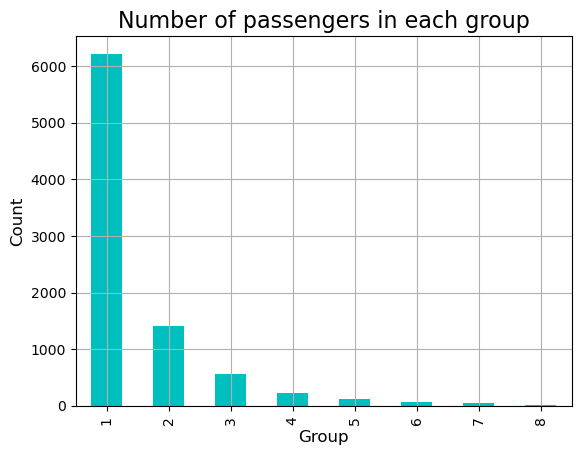

In [23]:
train_data['Group'].value_counts().plot(kind='bar', color='c');
plt.xlabel('Group', fontsize=12);
plt.ylabel('Count', fontsize=12);
plt.title("Number of passengers in each group", fontsize=16);
plt.grid(True)

In [24]:
train_data.head()

,CryoSleep,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Transported,Group,...,Earth,Mars,B,F,A,G,E,D,C,T
0,False,39.0,False,0.0,0.0,0.0,0.0,0.0,False,1,...,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
1,False,24.0,False,109.0,9.0,25.0,549.0,44.0,True,1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2,False,58.0,True,43.0,3576.0,0.0,6715.0,49.0,False,1,...,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,False,33.0,False,0.0,1283.0,371.0,3329.0,193.0,False,2,...,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,False,16.0,False,303.0,70.0,151.0,565.0,2.0,True,1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


In [25]:
X = train_data.drop("Transported", axis=1)
y = train_data['Transported']

In [26]:
X.isna().sum()

CryoSleep        0
Age              0
VIP              0
RoomService      0
FoodCourt        0
ShoppingMall     0
Spa              0
VRDeck           0
Group            0
Side             0
TRAPPIST-1e      0
PSO J318.5-22    0
55 Cancri e      0
Europa           0
Earth            0
Mars             0
B                0
F                0
A                0
G                0
E                0
D                0
C                0
T                0
dtype: int64

In [27]:
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=.3, random_state=17)

## Training a XGBClassifier model using a GridSearchCV

In [29]:
clf = xgb.XGBClassifier(objective='binary:logistic', random_state=17)

param_grid = {
    'n_estimators': [100, 200, 300],             # Number of trees
    'learning_rate': [0.01, 0.1, 0.2],           # Learning rate (gradient descent step)
    'max_depth': [3, 6, 9],                      # Maximum tree depth
    'min_child_weight': [1, 3, 5],               # Minimum sum of child weights in a node
    'subsample': [0.8, 1.0],                     # Fraction of subsample to train each tree
    'colsample_bytree': [0.8, 1.0],              # Fraction of features when building each tree
    'gamma': [0, 0.1, 0.2],                      # Minimum reduction in loss function to make splitting
    'reg_alpha': [0, 0.1, 0.5],                  # L1 regularization on tree leaf weights
    'reg_lambda': [0, 0.1, 0.5],                 # L2 regularization on tree leaf weights
    'scale_pos_weight': [1, 2, 3]                # Balancing class weights in case of unbalanced data
}
grid_search = GridSearchCV(clf, param_grid, cv=3, scoring='accuracy')

<font size="3">Note: the search takes a very long time (about 10 hours)</font>

In [30]:
grid_search.fit(X_train, y_train)

GridSearchCV(cv=3,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, gamma=None,
                                     gpu_id=None, grow_policy=None,
                                     importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None,...
                                     n_estimators=100, n_jobs=None,
                                     num_parallel_tree=None, predictor=None,
                                     random_state=17, ...),
             param_grid={'colsample_bytree

<font size="3">Best hyperparameters after iteration:</font>

In [49]:
grid_search.best_params_

{'colsample_bytree': 1.0,
 'gamma': 0.1,
 'learning_rate': 0.1,
 'max_depth': 3,
 'min_child_weight': 3,
 'n_estimators': 300,
 'reg_alpha': 0,
 'reg_lambda': 0.1,
 'scale_pos_weight': 1,
 'subsample': 1.0}

In [31]:
grid_search.score(X_train, y_train)

0.838455217748562

In [32]:
grid_search.score(X_test, y_test)

0.8006134969325154

In [33]:
best_model = grid_search.best_estimator_

## Prediction on a test sample  

In [34]:
test_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4277 entries, 0 to 4276
Data columns (total 13 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   PassengerId   4277 non-null   object 
 1   HomePlanet    4190 non-null   object 
 2   CryoSleep     4184 non-null   object 
 3   Cabin         4177 non-null   object 
 4   Destination   4185 non-null   object 
 5   Age           4186 non-null   float64
 6   VIP           4184 non-null   object 
 7   RoomService   4195 non-null   float64
 8   FoodCourt     4171 non-null   float64
 9   ShoppingMall  4179 non-null   float64
 10  Spa           4176 non-null   float64
 11  VRDeck        4197 non-null   float64
 12  Name          4183 non-null   object 
dtypes: float64(6), object(7)
memory usage: 434.5+ KB


In [35]:
test_data = fill_value(test_data)

In [36]:
passenger_id = test_data['PassengerId']

In [37]:
test_data.head()

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name
0,0013_01,Earth,True,G/3/S,TRAPPIST-1e,27.0,False,0.0,0.0,0.0,0.0,0.0,Nelly Carsoning
1,0018_01,Earth,False,F/4/S,TRAPPIST-1e,19.0,False,0.0,9.0,0.0,2823.0,0.0,Lerome Peckers
2,0019_01,Europa,True,C/0/S,55 Cancri e,31.0,False,0.0,0.0,0.0,0.0,0.0,Sabih Unhearfus
3,0021_01,Europa,False,C/1/S,TRAPPIST-1e,38.0,False,0.0,6652.0,0.0,181.0,585.0,Meratz Caltilter
4,0023_01,Earth,False,F/5/S,TRAPPIST-1e,20.0,False,10.0,0.0,635.0,0.0,0.0,Brence Harperez


In [38]:
test_data = add_new_feature(test_data)
test_data = FeatureEncoder(test_data)
test_data = drop_features(test_data)

In [39]:
bool_features_test = ['CryoSleep', 'VIP']
for col in bool_features_test:
    test_data[col] = test_data[col].map({False:0, True:1})

In [40]:
test_data['Side'] = test_data['Side'].map({"P": 1, "S":2})   

In [41]:
test_data.head()

,CryoSleep,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Group,Side,...,Earth,Mars,B,F,A,G,E,D,C,T
0,1,27.0,0,0.0,0.0,0.0,0.0,0.0,1,2,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,0,19.0,0,0.0,9.0,0.0,2823.0,0.0,1,2,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2,1,31.0,0,0.0,0.0,0.0,0.0,0.0,1,2,...,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
3,0,38.0,0,0.0,6652.0,0.0,181.0,585.0,1,2,...,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
4,0,20.0,0,10.0,0.0,635.0,0.0,0.0,1,2,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


In [42]:
predicted_values = best_model.predict(test_data)

In [43]:
predicted_values = pd.Series(predicted_values).map({1:True, 0:False})

In [44]:
predict_data = pd.DataFrame({"PassengerId":passenger_id,"Transported":predicted_values})

In [46]:
predict_data.to_csv("Predict_proba Xgboost.csv", index=False)

In [47]:
importances_f = pd.Series(best_model.feature_importances_, index = X.columns)

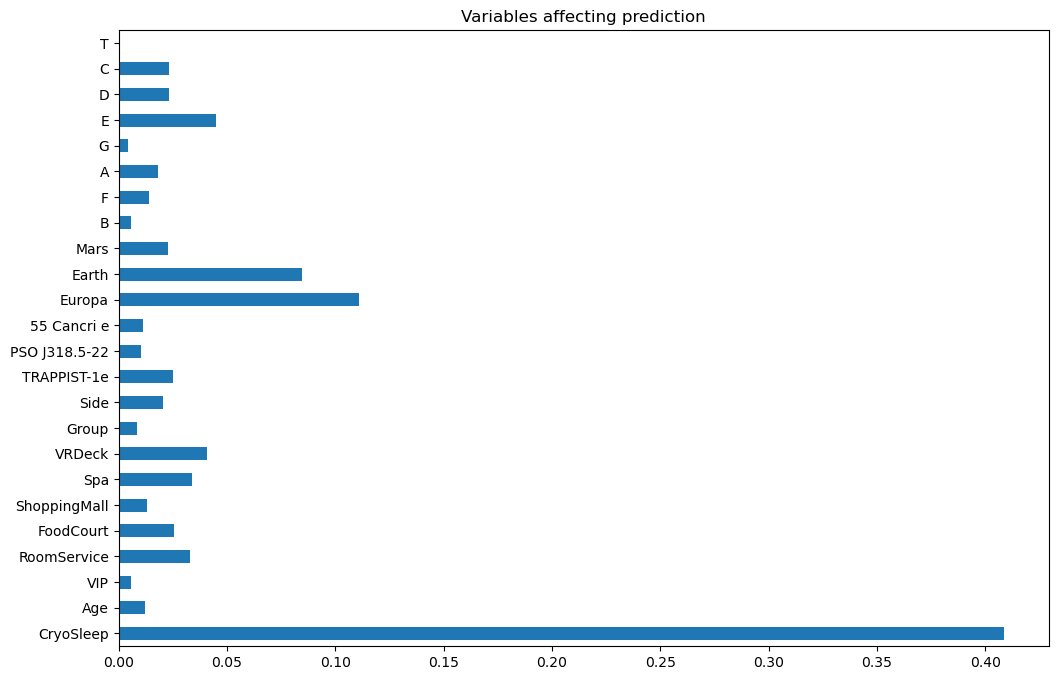

In [50]:
importances_f.plot(kind='barh', figsize=(12,8));
plt.title("Variables affecting prediction");

## Result

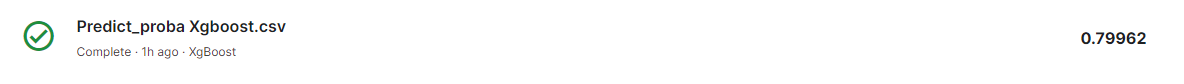

<font size="4">I claimed the 617th spot out of 2178.</font>

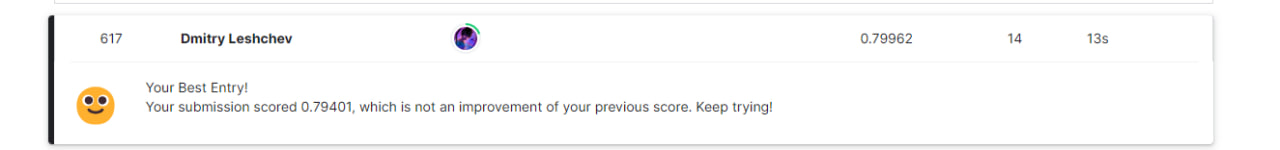